Class Information: Yonsei University CSI4121 2021-1 \
Student Information: Dongha Kim
　　

This report is about an implement of min-hashing. \
In this report, there are code explanation about how I implemented min-hashing, \
(docstrings, comments, and markdowns), and evaluations of errors \
between Jaccard similarity and estimated similarity.

###### this report's code requires python version upper than 3.7!

## Internal code - library information and system information

This code below is internal codes. \
In this portion, modules are loaded and datasets are prepared.

In [1]:
#
# Import modules and prepare datasets
#

# Framework and Utility import
import sys
import binascii
import functools
import platform
import random
import re
import time
import pandas as pd
import matplotlib.pyplot as plt

# Typing
try:
    import typing, types
except ImportError:
    typing = types = None


# Prepare Datasets
train_data = pd.read_csv('data/train.csv')
duplicate_data = train_data[train_data['is_duplicate'] == 1][['question1', 'question2']]

/
# Environment check
print(
    "ENVIRONMENT INFORMATION\nOS version: \t\t{0}\nPython version:\t\t{1}\n"
        .format(platform.platform(), sys.version)
)


ENVIRONMENT INFORMATION
OS version: 		Windows-10-10.0.19041-SP0
Python version:		3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]



# Implements of min-hashing

## Getters of Corpus, Shingling Vocabulary, Shingling-based integer matrix
I implemented partial getters. In docstrings and comments, there are explanations of how they work.

In [2]:
#
# Prepare corpus getter function. This function picks number of duplicated questions randomly.
#

def random_duplicate_questions(num, override_index=True, origin=duplicate_data):
    # type: (int, typing.Optional[bool], typing.Optional[pd.DataFrame]) -> pd.DataFrame
    """Prepares duplicated questions randomly.
:param num: number of questions
:param override_index: if true, override index value of pandas dataset
:param origin: origin of pandas datasets."""
    sample = origin.sample(num)
    if override_index:
        sample.index = list(range(num))
    return sample


#
# Prepare function that converts vocabulary to integer value. With this, we can make matrix.
#

# src: https://github.com/ppw0/minhash
# src: https://docs.python.org/ko/3/library/binascii.html
CRC32_MAX_HASH = 0xffffffff # the maximum hash number a shingle can have
CRC32_C = 4294967311 # next prime number larger than MAXHASH

def CRC32_FUNC(string):
    # type: (str) -> int
    """Returns CRC-32 checksum, which is 32-bit checksum of data, with given :param string:."""
    return binascii.crc32(string.encode()) & CRC32_MAX_HASH


#
# Prepare function that makes shingling-based integer from corpus.
#

def get_shingles_string_set(string, k):
    # type: (str, int) -> set[str]
    """Returns sets of :param k:-shingles of given :param string:"""
    shingle_set = set()
    words = re.sub(r'\s+', ' ', string).lower().split()
    for idx in range(len(words) - k + 1):
        shingle = ' '.join(words[idx:idx + k])
        if shingle not in shingle_set:
            shingle_set.add(shingle)
    return shingle_set


src 1: https://github.com/ppw0/minhash \
src 2: https://docs.python.org/ko/3/library/binascii.html


## Integrate partial functions to one function
This function integrates partial functions to one getter of shingling-based integer matrix.

In [3]:
#
# Prepare Shortcut Functions
#

def make_shingles_int_matrix(duplicate_question_dataset, k):
    # type: (pd.DataFrame, int) -> list[dict[str, set[int]]]
    """Returns lists of shingles_int_dict that function 'get_signature_matrix' requires,
from given question dataset and number of shingles(k)."""
    q1_q2_iter = zip(
        duplicate_question_dataset['question1'],
        duplicate_question_dataset['question2']
    )
    return [{
        'question1': {CRC32_FUNC(val) for val in get_shingles_string_set(q_1, k)},
        'question2': {CRC32_FUNC(val) for val in get_shingles_string_set(q_2, k)}
    } for q_1, q_2 in q1_q2_iter]


## Min-hashing Core Implement
In docstrings and comments, there are explanations of how they work.

In [4]:
#
# Implement Signature Matrix Function
#

def get_signature_matrix(shingles_int_dict, hash_func):
    # type: (dict[str, set[int]], typing.Union[int, list[types.FunctionType]]) -> pd.DataFrame
    """Calculates signature matrix by dictionary and hash functions.
:param shingles_int_dict: Dictionary's key should be name of row(e.g. 'question1'),
and value should be set of shingle integers.
:param hash_func: hash_func should be list of hash functions,
or number of hash functions."""
    if isinstance(hash_func, int):
        num_hash_func = hash_func
        hash_func = get_hash_func(hash_func)
    else:
        num_hash_func = len(hash_func)
    matrix_data = {}
    for idx, shingle_set in shingles_int_dict.items():
        signatures = []
        for j in range(num_hash_func):
            func = hash_func[j]
            min_hash = CRC32_C + 1
            for shingle in shingle_set:
                min_hash = min(min_hash, func(shingle))
            signatures.append(min_hash)
        matrix_data[idx] = signatures
    return pd.DataFrame(data=matrix_data)


#
# Prepare hash-function getter function.
#

def get_hash_func(num):
    # type: (int) -> list
    """Randomly prepare list of :param num: hash functions which receives one integer for argument."""
    def _get_coefficient(_num):
        # type: (int) -> set[int]
        _coffs = set()
        while _num > 0:
            _coff = random.randint(0, CRC32_MAX_HASH)
            if _coff not in _coffs:
                _coffs.add(_coff)
                _num -= 1
        return _coffs
    hash_func = []
    linear = lambda x, coff_a, coff_b: (coff_a * x + coff_b) % CRC32_C
    for a, b in zip(_get_coefficient(num), _get_coefficient(num)):
        hash_func.append(functools.partial(linear, coff_a=a, coff_b=b))
    return hash_func


## Similarity Function Implement
I made functions that calculate similarity of two dataset.

In [5]:
#
# Implement Similarity Functions
#

def jaccard_similarity(orig, comp):
    # type: (set[int], set[int]) -> float
    """Calculate Jaccard similarity, by given two sets of shingles-integer values."""
    return len(orig.intersection(comp)) / len(orig.union(comp))


def estimated_similarity(orig, comp, num_hash_func=None):
    # type: (typing.Sequence[int], typing.Sequence[int], typing.Optional[int, typing.Iterable]) -> float
    """Calculate estimated similarity, by given two iterables of signature matrix."""
    if num_hash_func is None:
        num_hash_func = min(len(orig), len(comp))
    elif not isinstance(num_hash_func, int):
        num_hash_func = len(num_hash_func)
    cnt = 0
    for idx in range(num_hash_func):
        if orig[idx] == comp[idx]:
            cnt += 1
    return cnt / num_hash_func


# Example Output

First, configure values for sample output.

In [6]:
_QUESTION_PAIR_SIZE = 10
_SHINGLES_SIZE = 3
_NUMBER_OF_HASH_FUNCTIONS = 1000

Then, this min-hashing implement will work like this!

In [7]:
sample_dataset = random_duplicate_questions(_QUESTION_PAIR_SIZE)
print("Corpus of sample dataset:")
sample_dataset

Corpus of sample dataset:


,question1,question2
0,How can I quit drinking cola?,How can I stop drinking cola?
1,What are some good ways to lose weight?,"What are the best ways to lose weight, especia..."
2,What was your experience earning a Master's de...,What is your experience with an online master'...
3,Which programming languages are used the most?...,Which is the most used programming language wh...
4,How will demonitization stop black money?,Will demonetisation really curb black money?
5,What is special about David Foster Wallace?,What is so great about David Foster Wallace?
6,How do women think differently from men?,Do men and women think differently? How?
7,Why is it compulsory to study Hindi as the thi...,Is it compulsory to study Hindi as the third l...
8,Where can I hire a real bad ass hacker?,How can I hire a professional hacker?
9,Would social media have helped Steve Bartman?,"If there had been social media in 2003, how wo..."


In [8]:
sample_hash_functions = get_hash_func(_NUMBER_OF_HASH_FUNCTIONS)
sample_shingles = make_shingles_int_matrix(sample_dataset, k=_SHINGLES_SIZE)
sample_signature_matrix = [get_signature_matrix(i, hash_func=sample_hash_functions) for i in sample_shingles]
print("Signature matrix of sample dataset:")
sample_signature_matrix[:3]


Signature matrix of sample dataset:


[      question1   question2
 0     127123208   127123208
 1    1598796569  1050925532
 2     569930746    43783120
 3     136776930   194570029
 4     951929280  2524504031
 ..          ...         ...
 995  1158781805   239094659
 996   301670123   301670123
 997   790569466  1911375552
 998   198614737   198614737
 999   476887906   839726361
 
 [1000 rows x 2 columns],
       question1  question2
 0     728625197  549819752
 1     821406213   56331033
 2     694208490  214349117
 3     390235580  194885157
 4    1380339185  454895106
 ..          ...        ...
 995   446275889   44010930
 996  1623338064  332059054
 997   957214903  882596256
 998   765239026  429504078
 999   465008796    8149726
 
 [1000 rows x 2 columns],
       question1   question2
 0      84627945    44344729
 1    1638597936   375526789
 2      51811516   239393674
 3     707409149   186321427
 4    1138494306   127386938
 ..          ...         ...
 995   860985772   250327648
 996   139464152   549656644

In [9]:
sample_jaccard_sims = [
    jaccard_similarity(i['question1'], i['question2'])
    for i in sample_shingles
]
sample_estimated_sims = [
    estimated_similarity(j['question1'], j['question2'], num_hash_func=_NUMBER_OF_HASH_FUNCTIONS)
    for j in sample_signature_matrix
]
sample_similarity_errors = [
    abs(i - j) for i, j in zip(sample_jaccard_sims, sample_estimated_sims)
]
sample_avg_jaccard_sim = sum(sample_jaccard_sims) / len(sample_jaccard_sims)
sample_avg_estimated_sim = sum(sample_jaccard_sims) / len(sample_jaccard_sims)
sample_avg_error = sum(sample_similarity_errors) / len(sample_similarity_errors)

print("""Average Jaccard Similarities: {:.4f}
Average Estimated Similarities: {:.4f}
Average Error of Sample Datasets: {:.4f}""".format(
    sample_avg_jaccard_sim, sample_avg_estimated_sim, sample_avg_error
))


Average Jaccard Similarities: 0.1541
Average Estimated Similarities: 0.1541
Average Error of Sample Datasets: 0.0036


# Evaluate Min-hashing
Now we can evaluate model performance, \
with different portion of train data and epochs.

## Configure range of evaluation

Configure number of question pairs

In [10]:
QUESTION_PAIR_SIZE = [10, 100]

Configure size of shingles

In [11]:
SHINGLES_SIZE = [3, 4, 5]

Configure number of hash functions

In [12]:
NUMBER_OF_HASH_FUNCTIONS = [1, 2, 3, 4, *range(5, 1000 + 1, 5)]

## Evaluation Result

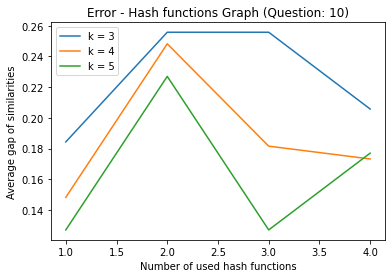

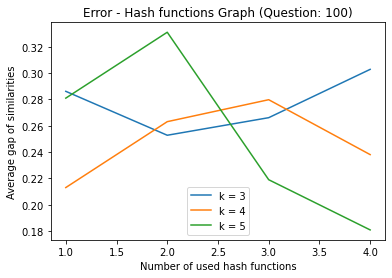

In [13]:
graphs_all = {}


for size_q in QUESTION_PAIR_SIZE:  # enumerate object for reporthook

    graphs_each_question = graphs_all[size_q] = {}
    dataset = random_duplicate_questions(size_q)

    for size_s in SHINGLES_SIZE:

        graph = graphs_each_question[size_s] = []
        shingles = make_shingles_int_matrix(dataset, k=size_s)

        for size_h in NUMBER_OF_HASH_FUNCTIONS:

            hash_functions = get_hash_func(size_h)
            signature_matrix = [
                get_signature_matrix(i, hash_func=hash_functions)
                for i in sample_shingles
            ]

            sim_errs = [
                abs(
                    jaccard_similarity(i['question1'], i['question2'])
                    - estimated_similarity(j['question1'], j['question2'], num_hash_func=size_h)
                )
                for i, j in zip(shingles, signature_matrix)
            ]

            if not sim_errs:
                sys.exit(1)

            average_error = sum(sim_errs) / len(sim_errs)
            graph.append(average_error)


for size_q, graphs_each_q in graphs_all.items():

    for size_s, graph_y in graphs_each_q.items():

        plt.plot(NUMBER_OF_HASH_FUNCTIONS, graph_y, label='k = {}'.format(size_s))

    plt.xlabel('Number of used hash functions')
    plt.ylabel('Average gap of similarities')
    plt.title('Error - Hash functions Graph (Question: {})'.format(size_q))
    plt.legend()
    plt.show()


In graphs above, the more hash functions we use, the less gap of Jaccard similarity and estimated similarity with signature matrix there are. 


# References

1: https://github.com/ppw0/minhash \
2: https://docs.python.org/ko/3/library/binascii.html

Thank you.